In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Script to forecast variable using multivariate LSTM

from pandas import DataFrame
from pandas import read_csv
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import concatenate
from numpy import diff
import numpy
import pandas


In [2]:
# To get reproducible results with Keras
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [4]:
# load dataset - y on first column
dataset_x = read_csv('var_x.csv', header=0, index_col=0)
dataset_y = read_csv('var_y.csv', header=0, index_col=0)
dataset_z = read_csv('var_z.csv', header=0, index_col=0)
dataset_z = dataset_z.drop(['etc1','etc2','etc3'], 1) # remove columns (1) that won't be used
dataset = concat([dataset_y,dataset_x,dataset_z], axis=1)
values = dataset.values

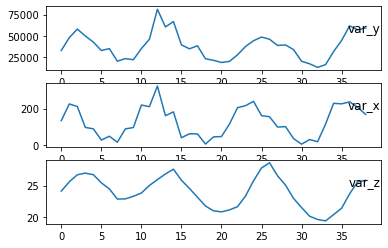

In [5]:
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
pyplot.savefig('series.png')
pyplot.close('all')

In [6]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)

In [7]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.291608,0.404361,0.512596,0.511645
2,0.511645,0.691277,0.672508,0.659433
3,0.659433,0.647352,0.792990,0.539782
4,0.539782,0.287850,0.821468,0.435016
5,0.435016,0.263551,0.795181,0.290686
6,0.290686,0.070405,0.653888,0.323426
7,0.323426,0.136137,0.550931,0.106558
8,0.106558,0.033333,0.375685,0.151298
9,0.151298,0.262928,0.378970,0.131854
10,0.131854,0.285358,0.422782,0.323081


In [8]:
# split into train and test sets
values = reframed.values
n_train = -12 # last 12 months to test
train, test = values[0:n_train], values[n_train:]
# split into input (all columns exceptc last one) and outputs (last column)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26, 1, 3) (26,) (12, 1, 3) (12,)


In [9]:
# design network
neurons = 50
batch_size = 1
epochs = 100
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [10]:
#model

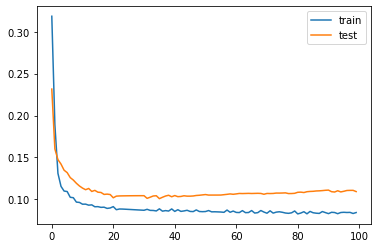

In [11]:
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.clf()
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig('loss.png')
pyplot.close('all')


In [12]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual - observed data
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9219.457


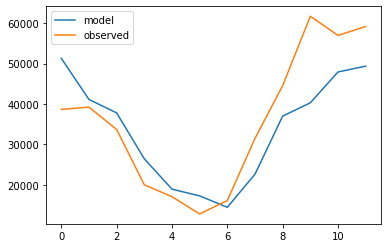

In [13]:
# plot baseline and predictions
pyplot.clf()
pyplot.plot(inv_yhat, label="model")
pyplot.plot(inv_y, label="observed")
pyplot.legend()
pyplot.show()
pyplot.savefig('test_and_train.png')
pyplot.close('all')